# Rasterio: Reading and Writing Data, Descriptive Information  

When you're working in with rasters in Rasterio, a typical workflow is often reading data, doing something to it, and then writing out a new dataset. To perform these i/o type tasks, accessing descriptive info about the dataset is also essential. 

Start by importing libraries:  
```python
import numpy as np
import rasterio as rio
from rasterio.plot import show
import os
```

In [3]:
import numpy as np
import rasterio as rio
from rasterio.plot import show
import os

Important: only run this once or you'll wind up in the wrong directory.
```python
os.chdir('../')
os.getcwd()
```

First, we'll read in a raster as a Rasterio dataset object:  

```python
src = rio.open('workshopdata/dem.tif')
```

In [39]:
src = rio.open('workshopdata/dem.tif')

Just so you know what you're looking at... 

```python
show(src)
```

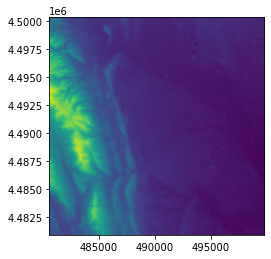

<AxesSubplot:>

In [40]:
show(src)

More visualization later...  

#### Let's go over some descriptive attributes:  

```python
src.name
```

In [41]:
src.name

'workshopdata/dem.tif'

```python
src.width
```

In [42]:
src.width

639

```python
src.height
```

In [43]:
src.height

646

Check the coordinate reference system (CRS)
```python
src.crs
```

In [44]:
src.crs

CRS.from_epsg(3743)

How many bands are in this image?  
```python
src.count
```

In [45]:
src.count

1

The unit is part of the coordinate system:
```python
src.crs.linear_units
```

In [46]:
src.crs.linear_units

'metre'

Now, let's get the extent AKA bounds:
```python
src.bounds
```

In [47]:
src.bounds

BoundingBox(left=480578.7851666603, bottom=4480922.522612451, right=499748.7851666603, top=4500302.522612451)

Affine transformation:
```python
src.transform
```

In [48]:
src.transform

Affine(30.0, 0.0, 480578.7851666603,
       0.0, -30.0, 4500302.522612451)

Transform is super important, but what the heck is it?  

(cell width, x origin, x origin coordinate, y origin, cell height, y origin coordinate)

**From Rasterio's docs:** 
A dataset’s `DatasetReader.transform` is an [affine transformation matrix](https://en.wikipedia.org/wiki/Affine_transformation) that maps pixel locations in (row, col) coordinates to (x, y) spatial positions. The product of this matrix and (0, 0), the row and column coordinates of the upper left corner of the dataset, is the spatial position of the upper left corner.  
  
Upper left corner position is (0,0), so...  
```python
src.transform * (0,0)
```

In [49]:
src.transform*(100,100)

(483578.7851666603, 4497302.522612451)

There's the coordinates of our top left corner...  

For funsies, we could take a stab at the center point, or at least pretty darn close:
```python
centerX = src.width/2
centerY = src.height/2
```

In [50]:
centerX = src.width/2

In [51]:
centerY = src.height/2

```python
src.transform * (centerX,centerY)
```

In [52]:
src.transform*(centerX,centerY)

(490163.7851666603, 4490612.522612451)

So, that's how you apply a transformation--it does the math over the pixels to "georeference" them to a coordinate system, or change it from one crs to another... which we'll work on in the next notebook.  

You can access parts of the transform as well, such as cell dimensions:
```python
cellWidth = src.transform[0]
cellHeight = src.transform[4]
```

In [53]:
cellWidth = src.transform[0]
cellHeight = src.transform[4]

```python
cellWidth, cellHeight
```

In [54]:
cellWidth, cellHeight

(30.0, -30.0)

Okay, and finally two related and important descriptive tools:
```python
src.meta
```

In [55]:
src.meta

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': 32767.0,
 'width': 639,
 'height': 646,
 'count': 1,
 'crs': CRS.from_epsg(3743),
 'transform': Affine(30.0, 0.0, 480578.7851666603,
        0.0, -30.0, 4500302.522612451)}

And similar...  

```python
src.profile
```

In [56]:
src.profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 32767.0, 'width': 639, 'height': 646, 'count': 1, 'crs': CRS.from_epsg(3743), 'transform': Affine(30.0, 0.0, 480578.7851666603,
       0.0, -30.0, 4500302.522612451), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

Note that you can access these:  
```python
src.meta['dtype']
```

In [57]:
src.profile['dtype']

'int32'

Now let's do a little bit of work on the raster layer and save it's output to a new file.  

Frequently, Numpy is used to work with arrays--and a raster layer is just a big ol' array...  

To read a Rasterio dataset object as a Numpy array use src.read(). The parameter is the band you want to read:

```python
array = src.read(1)
```

In [58]:
array = src.read(1)

And here it is... 

```python
array
```

In [59]:
array

array([[1749, 1745, 1746, ..., 1549, 1549, 1550],
       [1738, 1734, 1732, ..., 1548, 1548, 1547],
       [1730, 1720, 1717, ..., 1548, 1546, 1545],
       ...,
       [1670, 1665, 1664, ..., 1495, 1494, 1494],
       [1670, 1665, 1664, ..., 1497, 1496, 1493],
       [1677, 1669, 1665, ..., 1497, 1496, 1493]])

Now, let's do something super basic for now: multiply every value in the array times 2...   
```python
array2 = array * 2
```

In [60]:
array2 = array*2

Did it work?

```python
print(array.max())
print(array2.max())
```

In [61]:
print(array.max())
print(array2.max())

2247
4494


Complex analysis, right?  

Let's grab the height and width of our array2 and save them for later... note that these should be exactly the same as our source DEM, so in this case, you could also use src.width and src.height...  

But we'll use the Numpy method:
```python
height = np.size(array2,0)
width = np.size(array2,1)
```

In [62]:
height = np.size(array2,0)
width = np.size(array2,1)

Okay, let's take our new data and write it to a new GeoTiff file.  

The steps are: 
1. Open a new array in write mode--with all the correct parameters... 
2. Write the array into the Rasterio dataset object
3. Close it

So, begin by creating and opening a new GeoTiff that will store our data...  

First let's take a look at the documentation: https://rasterio.readthedocs.io/en/latest/quickstart.html#opening-a-dataset-in-writing-mode

The parameters we need are:
- driver: the name of the desired format driver
- width: the number of columns of the dataset
- height: the number of rows of the dataset
- count: a count of the dataset bands
- dtype: the data type of the dataset
- crs: a coordinate reference system identifier or description
- transform: an affine transformation matrix  

Note that several of these are optional, but you probably want to use at least these. And there are more optional params as well...  

For starters let's do this:

```python
new = rio.open('new_dem.tif', 'w', 
               driver='GTiff', 
               height = height, 
               width = width, 
               count = 1, 
               dtype = src.meta['dtype'], 
               crs = src.crs, 
               transform = src.transform)
```

In [63]:
new = rio.open('new_dem.tif', 'w', 
               driver = 'GTiff', 
               height = src.height, 
               width = src.width, 
               count=1, 
               dtype = src.meta['dtype'], 
               crs = src.crs, 
               transform = src.transform)

Now write the array to the open data set:
```python
new.write(array2,1)
```

In [64]:
new.write(array2,1)

Close it when you're done:  
```
new.close()
```

In [65]:
new.close()

#### That's it!   
The basic gist is that you need the descriptive info (meta, profile, crs, transform, width, height, dtype, etc) to write a new dataset.  

#### However!  
There is a slightly more streamlined approach where you use the meta/profile of the source image and repurpose it (and modify if needed) and use it in the destination image....  

First, note that the `.meta` and `.profile` information has all the same parameters that you need to open a brand new dataset in write mode:  

```python
src.meta
```

In [66]:
src.meta

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': 32767.0,
 'width': 639,
 'height': 646,
 'count': 1,
 'crs': CRS.from_epsg(3743),
 'transform': Affine(30.0, 0.0, 480578.7851666603,
        0.0, -30.0, 4500302.522612451)}

Same stuff!  

Okay, make a copy of it to a new variable, we'll call it kwargs, which is short for key word arguments:
```python
kwargs = src.meta.copy()
```

In [67]:
kwargs = src.meta.copy()

Okay, now we have all the parameters necessary saved in a dict, which is of course, key:value pairs....  

In this case, none of them need updating because all we did was double the values in the array, we didn't modify it's shape at all so... 

Just open a new Rasterio data oject in write mode and apply the kwargs like this:
```python
new = rio.open('new_dem.tif', 'w', **kwargs)
```

In [68]:
new = rio.open('new_dem.tif', 'w', **kwargs)

That's called a **double star expression**--it is used to unpack keyword arguments as parameters of a function.  

And now, same as before, write and close:
```
new.write(array2,1)
new.close()
```

In [69]:
new.write(array2,1)
new.close()

### DONE!